# RCNN experiment

#### My Environment
```text
            .-/+oossssoo+/-.               lixe@phtmaiden 
        `:+ssssssssssssssssss+:`           -------------- 
      -+ssssssssssssssssssyyssss+-         OS: Ubuntu 24.04.2 LTS x86_64 
    .ossssssssssssssssssdMMMNysssso.       Host: ROG Strix G733ZS_G733ZS 1.0 
   /ssssssssssshdmmNNmmyNMMMMhssssss/      Kernel: 6.11.0-26-generic 
  +ssssssssshmydMMMMMMMNddddyssssssss+     Uptime: 13 hours, 14 mins 
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/    Packages: 2180 (dpkg), 19 (snap) 
.ssssssssdMMMNhsssssssssshNMMMdssssssss.   Shell: bash 5.2.21 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+   Resolution: 2560x1440 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso   DE: GNOME 46.0 
ossyNMMMNyMMhsssssssssssssshmmmhssssssso   WM: Mutter 
+sssshhhyNMMNyssssssssssssyNMMMysssssss+   WM Theme: Adwaita 
.ssssssssdMMMNhsssssssssshNMMMdssssssss.   Theme: WhiteSur-Light-solid [GTK2/3] 
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/    Icons: WhiteSur [GTK2/3] 
  +sssssssssdmydMMMMMMMMddddyssssssss+     Terminal: xfce4-terminal 
   /ssssssssssshdmNNNNmyNMMMMhssssss/      Terminal Font: Monospace 12 
    .ossssssssssssssssssdMMMNysssso.       CPU: 12th Gen Intel i9-12900H (20) @ 4.900GHz 
      -+sssssssssssssssssyyyssss+-         GPU: NVIDIA GeForce RTX 3080 Mobile / Max-Q 8GB/16GB 
        `:+ssssssssssssssssss+:`           GPU: Intel Alder Lake-P GT2 [Iris Xe Graphics] 
             .-/+oossssoo+/-.              Memory: 13480MiB / 63959MiB 
```

VOC data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Unzip this data and store this as `VOCdevkit` like below setup 
```text
lixe@phtmaiden:~/RCNNLocalTest$ ls -al .
total 2776
drwxrwxr-x  8 lixe lixe    4096 Jun  3 00:04 .
drwxr-x--- 39 lixe lixe    4096 Jun  3 00:04 ..
-rw-rw-r--  1 lixe lixe 2799698 Jun  2 22:54 experiment0.ipynb
drwxrwxr-x  7 lixe lixe    4096 Jun  3 00:04 .git
-rw-rw-r--  1 lixe lixe      36 Jun  3 00:04 .gitignore
drwxrwxr-x  2 lixe lixe    4096 Jun  1 14:44 __pycache__
drwxrwxr-x  4 lixe lixe    4096 Jun  2 22:54 RCNNDataCache
-rw-rw-r--  1 lixe lixe    1451 Jun  1 14:17 requirements.txt
drwxrwxr-x  2 lixe lixe    4096 Jun  2 00:18 screenshots
drwxrwxr-x  6 lixe lixe    4096 May 31 21:40 .venv
drwxrwxr-x  3 lixe lixe    4096 Jun  1 15:24 VOCdevkit <---- Downloaded VOC 2007 data (unzipped)
```

The VOC data looks like below.
```text
VOCdevkit
  VOC2007
    Annotations
    ImageSets
    JPEGImages
    SegmentationClass
    SegmentationObject
```

In [1]:
%pip install torch torchvision scikit-learn opencv-python lxml matplotlib
%pip install cython pycocotools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torchvision.datasets import VOCDetection

# Load the VOC dataset using the unzipped directory
voc_dataset = VOCDetection(
    root='.', # Root is now the parent directory of VOCdevkit
    year='2007',
    image_set='trainval',
    download=False, # Set download to False since we are loading from a local file
    transform=None,
    target_transform=None
)

print("VOC dataset loaded successfully.")

VOC dataset loaded successfully.


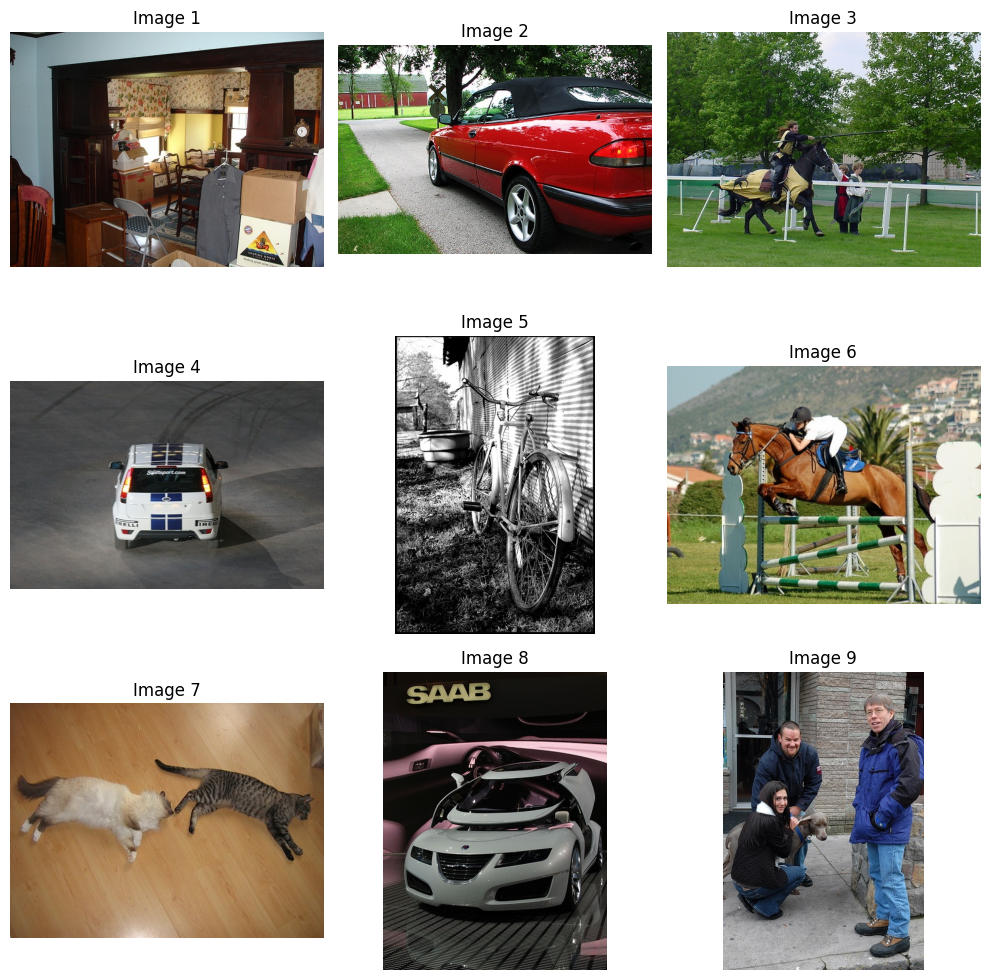

In [3]:
import matplotlib.pyplot as plt

# Define the number of images to display in a grid
num_images_to_display = 9
grid_size = int(num_images_to_display**0.5)

plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    # Only print images :)
    img, _ = voc_dataset[i]

    plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(img)
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Generate region proposals with selective search

In [4]:
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [6]:
image_path = './VOCdevkit/VOC2007/JPEGImages/000001.jpg'
image = cv2.imread(image_path)

# Ensure image is loaded
if image is None:
    print(f"Error loading image: {image_path}")
else:
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()            # or switchToSelectiveSearchQuality()
    rects = ss.process()                        # list of (x, y, w, h)
    proposals = rects[:2000]                    # keep top 2000 (for speed/consistency)

    # Filter out small proposals
    proposals = [p for p in proposals if p[2] >= 20 and p[3] >= 20]

    # Create a copy of the image to draw rectangles on
    image_with_proposals = image.copy()

    # Draw the top N proposals on the image
    num_proposals_to_show = 50 # Adjust this number to show more or fewer proposals
    for i, rect in enumerate(proposals[:num_proposals_to_show]):
        x, y, w, h = rect
        cv2.rectangle(image_with_proposals, (x, y), (x + w, y + h), (0, 255, 0), 2) # Draw a green rectangle

    # Convert the image from BGR to RGB for displaying with matplotlib
    image_with_proposals_rgb = cv2.cvtColor(image_with_proposals, cv2.COLOR_BGR2RGB)

    # Display the image with proposals
    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_proposals_rgb)
    plt.title(f'Image with Top {num_proposals_to_show} Region Proposals')
    plt.axis('off')
    plt.show()

Error loading image: ./VOCdevkit/VOC2007/JPEGImages/000001.jpg


[ WARN:0@0.024] global loadsave.cpp:268 findDecoder imread_('./VOCdevkit/VOC2007/JPEGImages/000001.jpg'): can't open/read file: check file path/integrity


### Warp/Crop and save images

In [7]:
import cv2

def warp_and_save(image, box: tuple[int,int,int,int], output_path: str) -> bool:
    """
    Crop a region from `image` and resize to 227x227, then save to `output_path`.
    Returns True if saved successfully, False otherwise.
    """
    x, y, w, h = box
    # 1) Crop via NumPy slicing
    crop = image[y : y + h, x : x + w]

    # 2) If crop is empty or invalid, skip saving
    if crop is None or crop.shape[0] == 0 or crop.shape[1] == 0:
        return False

    # 3) Resize to 227×227 (according to the R-CNN paper!)
    resized = cv2.resize(crop, (227, 227), interpolation = cv2.INTER_LINEAR)

    # 4) Save with cv2.imwrite
    success = cv2.imwrite(output_path, resized)
    return success
import cv2

Get all available image IDs

In [8]:
import os
import re

# 1) Define directory path
jpg_dir = './VOCdevkit/VOC2007/JPEGImages'

# 2) List all entries and filter for .jpg files
all_files = os.listdir(jpg_dir)
jpg_filenames = [f for f in all_files if f.lower().endswith('.jpg')]

# 3) Strip extensions to get base names
base_names = [os.path.splitext(fname)[0] for fname in jpg_filenames]

# 4) Use regex to extract numeric portions
regex = re.compile(r'\d+')
numeric_ids = []
for name in base_names:
    m = regex.search(name)
    if m:
        numeric_ids.append(int(m.group()))
# If numeric_ids is empty, raise an error
if not numeric_ids:
    raise RuntimeError(f"No numeric filenames found in {jpg_dir}")

# 5) Find min and max
min_id = min(numeric_ids)
max_id = max(numeric_ids)

print(f"Numeric ID range discovered: {min_id} to {max_id}")

# 6) Reconstruct zero-padded strings (assuming 6 digits total)
num_digits = 6
all_ids_in_range = [f"{i:0{num_digits}d}" for i in range(min_id, max_id + 1)]

# 7) Filter to those that actually exist on disk
existing_ids = set(base_names)
trainval_ids = [img_id for img_id in all_ids_in_range if img_id in existing_ids]

print(f"Total valid img_id strings found: {len(trainval_ids)}")

Numeric ID range discovered: 5 to 9961
Total valid img_id strings found: 5011


Get all possible proposal regions as a Python3 dictionary form

In [9]:
import cv2

# Create a global SS object so that each worker process can initialize it once
_ss_global = None

def init_ss():
    global _ss_global
    _ss_global = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def compute_proposals_for_image(img_id):
    """
    Worker function for multiprocessing.
    Loads image, runs Selective Search, returns a tuple: (img_id, filtered_boxes).
    """
    global _ss_global
    # Load image
    img_path = f'./VOCdevkit/VOC2007/JPEGImages/{img_id}.jpg'
    image = cv2.imread(img_path)
    if image is None:
        return (img_id, [])  # skip if missing

    # Configure and run SS
    _ss_global.setBaseImage(image)
    _ss_global.switchToSelectiveSearchFast()
    rects = _ss_global.process()
    top_rects = rects[:300]  # Keep 300 out of 2,000 top proposals.
    # NOTE: I tried 50, but it was too poor. mAP is 0.04 ~ 0.1. What the f***?????
    # NOTE: I tried 500, then my computer crashed.

    # Filter out tiny ones
    filtered = [r for r in top_rects if r[2] >= 20 and r[3] >= 20]
    return (img_id, filtered)

Building proposal regions. It consumes CPU due to the package's internal logic so I utilized parallelism and (really, you won't truly understand my anger and frustration) switched the environment from Google colab to my lovely laptop with i9-12900 CPU.

![image_region_proposal_screenshot.png](./screenshots/image_region_proposal_screenshot.png)

In [10]:
import multiprocessing as mp
import glob
import os

num_workers = mp.cpu_count() - 1 or 1  # don’t lock up every core
with mp.Pool(processes=num_workers, initializer=init_ss) as pool:
    results = []
    for idx, res in enumerate(pool.imap(compute_proposals_for_image, trainval_ids), 1):
        results.append(res)
        print(f"[{idx / len(trainval_ids) * 100:.2f}%] {idx} / {len(trainval_ids)} images processed")

# Merge with any previously processed results if needed
proposals_dict = {img_id: boxes for (img_id, boxes) in results}

[0.02%] 1 / 5011 images processed
[0.04%] 2 / 5011 images processed
[0.06%] 3 / 5011 images processed
[0.08%] 4 / 5011 images processed
[0.10%] 5 / 5011 images processed
[0.12%] 6 / 5011 images processed
[0.14%] 7 / 5011 images processed
[0.16%] 8 / 5011 images processed
[0.18%] 9 / 5011 images processed
[0.20%] 10 / 5011 images processed
[0.22%] 11 / 5011 images processed
[0.24%] 12 / 5011 images processed
[0.26%] 13 / 5011 images processed
[0.28%] 14 / 5011 images processed
[0.30%] 15 / 5011 images processed
[0.32%] 16 / 5011 images processed
[0.34%] 17 / 5011 images processed
[0.36%] 18 / 5011 images processed
[0.38%] 19 / 5011 images processed
[0.40%] 20 / 5011 images processed
[0.42%] 21 / 5011 images processed
[0.44%] 22 / 5011 images processed
[0.46%] 23 / 5011 images processed
[0.48%] 24 / 5011 images processed
[0.50%] 25 / 5011 images processed
[0.52%] 26 / 5011 images processed
[0.54%] 27 / 5011 images processed
[0.56%] 28 / 5011 images processed
[0.58%] 29 / 5011 images proc

In [11]:
# Print the proposals for the first 5 images
for img_id in list(proposals_dict.keys())[:5]:
    print(f"Image ID: {img_id}, Proposals: {len(proposals_dict[img_id])}")

Image ID: 000005, Proposals: 170
Image ID: 000007, Proposals: 180
Image ID: 000009, Proposals: 189
Image ID: 000012, Proposals: 180
Image ID: 000016, Proposals: 180


In [12]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [13]:
from tqdm import tqdm

os.makedirs('./RCNNDataCache/warped_patches', exist_ok=True)

for img_id, boxes in tqdm(proposals_dict.items(), desc="Saving warped patches"):
    path = f'./VOCdevkit/VOC2007/JPEGImages/{img_id}.jpg'
    image = cv2.imread(path)
    if image is None:
        print(f"Error loading image: {path}")
        continue
    for i, box in enumerate(boxes):
        out_name = f'{img_id}_{i}.jpg'
        out_path = os.path.join('./RCNNDataCache/warped_patches', out_name)
        if os.path.exists(out_path):
            continue  # Skip if file already exists
        warp_and_save(image, box, out_path)

Saving warped patches:   0%|          | 0/5011 [00:00<?, ?it/s]

Saving warped patches: 100%|██████████| 5011/5011 [03:14<00:00, 25.82it/s]


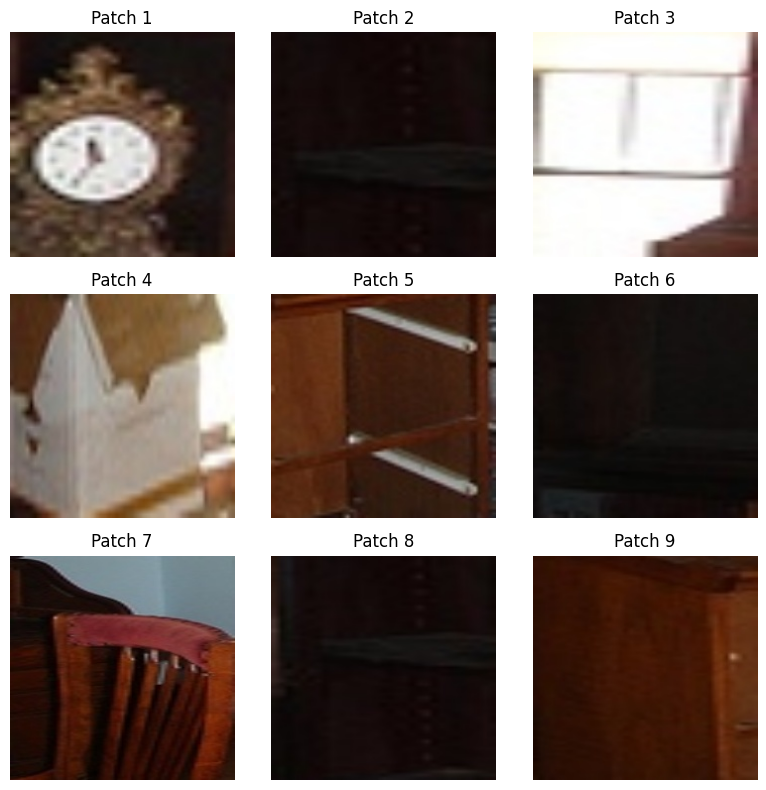

In [14]:
import matplotlib.pyplot as plt

# Display some of the saved patches to verify they were created correctly
patch_filenames = [
    './RCNNDataCache/warped_patches/000005_0.jpg',
    './RCNNDataCache/warped_patches/000005_1.jpg',
    './RCNNDataCache/warped_patches/000005_2.jpg',
    './RCNNDataCache/warped_patches/000005_3.jpg',
    './RCNNDataCache/warped_patches/000005_4.jpg',
    './RCNNDataCache/warped_patches/000005_5.jpg',
    './RCNNDataCache/warped_patches/000005_6.jpg',
    './RCNNDataCache/warped_patches/000005_7.jpg',
    './RCNNDataCache/warped_patches/000005_8.jpg'
]

plt.figure(figsize=(8, 8))
for i, fname in enumerate(patch_filenames):
    patch = cv2.imread(fname)
    patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(patch_rgb)
    plt.axis('off')
    plt.title(f'Patch {i+1}')
plt.tight_layout()
plt.show()

## Train models...

In [15]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer
import joblib  # for saving/loading scikit-learn models
import cv2
import matplotlib.pyplot as plt

In [16]:
# Define class names and label mapping
VOC_CLASSES = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',''
    'tvmonitor'
]
CLASS_TO_IDX = {cls_name: idx for idx, cls_name in enumerate(VOC_CLASSES)}

# Custom Dataset
class RCNNDataset(Dataset):
    """
    PyTorch Dataset to load warped proposal patches and corresponding labels for fine-tuning.
    Expects a CSV-like index file where each row contains:
      img_id (str), proposal_idx (int), label (int), x, y, w, h
    """
    def __init__(self, index_file, patches_dir, transforms=None):
        """
        index_file: path to a text file or CSV listing every patch and its label/box.
        patches_dir: directory where warped patches (227x227) are stored.
        transforms: torchvision transforms to apply to each patch.
        """
        # Read lines: each line: img_id,proposal_idx,label,x,y,w,h
        with open(index_file, 'r') as f:
            lines = [line.strip().split(',') for line in f if line.strip()]
        self.entries = []
        for tokens in lines:
            img_id, prop_idx, label, x, y, w, h = tokens
            self.entries.append({
                'img_id': img_id,
                'prop_idx': int(prop_idx),
                'label': int(label),
                'bbox': (int(x), int(y), int(w), int(h))
            })
        self.patches_dir = patches_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        ent = self.entries[idx]
        img_id = ent['img_id']
        prop_idx = ent['prop_idx']
        label = ent['label']
        
        # Build path: e.g., '000005_12.jpg'
        fname = f"{img_id}_{prop_idx}.jpg"
        img_path = os.path.join(self.patches_dir, fname)
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Patch not found: {img_path}")
        
        # Convert BGR -> RGB, then to PIL for torchvision transforms
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to PIL.Image
        image = transforms.ToPILImage()(image)
        if self.transforms:
            image = self.transforms(image)
        return image, label, ent['bbox'], img_id

Generate `index_file.txt` Containing (img_id, proposal_idx, label, x, y, w, h).
We need to scan through every `img_id` in `trainval_ids`, and for each of its proposals (from `proposals_dict`), compute IoU with ground-truth boxes (in VOC XML) to decide if it’s a positive (label=c) or a negative (label=20 as “background”).  

In [18]:
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    """
    Parse a VOC XML annotation and return a list of dicts:
        [{'class': 'person', 'bbox': (xmin, ymin, xmax, ymax)}, ...]
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    objs = []
    for obj in root.findall('object'):
        cls_name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        objs.append({'class': cls_name, 'bbox': (xmin, ymin, xmax, ymax)})
    return objs

def compute_iou(boxA, boxB):
    """
    Compute IoU between two boxes in (xmin,ymin,xmax,ymax) format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA + 1)# Visualize training loss and accuracy
    interH = max(0, yB - yA + 1)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    unionArea = boxAArea + boxBArea - interArea
    if unionArea == 0:
        return 0.0
    return interArea / unionArea

# Path definitions
annotations_dir = './VOCdevkit/VOC2007/Annotations'
patches_dir = './RCNNDataCache/warped_patches'
index_file = './RCNNDataCache/rcnn_index.txt'

# Build the index file
with open(index_file, 'w') as idx_f:
    # Write header (optional)
    # idx_f.write('img_id,prop_idx,label,x,y,w,h\n')
    for img_id in trainval_ids:
        # Load GT boxes for this image
        xml_path = os.path.join(annotations_dir, f"{img_id}.xml")
        gt_objects = parse_voc_annotation(xml_path)

        # Convert GT boxes to (xmin,ymin,xmax,ymax)
        gt_boxes = []
        gt_labels = []  # parallel list of class indices
        for obj in gt_objects:
            xmin, ymin, xmax, ymax = obj['bbox']
            gt_boxes.append((xmin, ymin, xmax, ymax))
            gt_labels.append(CLASS_TO_IDX[obj['class']])

        # Iterate proposals
        for prop_idx, (x, y, w, h) in enumerate(proposals_dict[img_id]):
            # Convert proposal to (xmin,ymin,xmax,ymax)
            prop_box = (x, y, x + w, y + h)

            # Determine IoU with all GT boxes
            best_iou = 0.0
            best_label = 20  # default to background index
            for gt_box, gt_label in zip(gt_boxes, gt_labels):
                iou = compute_iou(prop_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_label = gt_label

            # Label criteria: IoU > 0.5 => positive class
            #                 IoU < 0.3 => negative class
            if best_iou >= 0.5:
                label = best_label
            elif best_iou < 0.3:
                label = 20  # background
            else:
                # Ambiguous: IoU in [0.3, 0.5), skip this proposal
                continue

            # Write a line: img_id,prop_idx,label,x,y,w,h
            idx_f.write(f"{img_id},{prop_idx},{label},{x},{y},{w},{h}\n")

# The data will be look like...
# 000005,0,20,367,223,67,80
# 000005,1,20,163,161,55,43
# 000005,2,20,256,119,90,66
# 000005,3,20,369,345,65,26
# 000005,4,20,450,137,44,49
# 000005,5,20,103,130,64,78
# 000005,6,8,281,191,44,34

Set Up Image Transforms and Create `DataLoader` for Fine-Tuning

We resize (again! we've already done in the previous ipynb cell.) to 227×227 to be safe, convert to tensor, and normalize using ImageNet’s mean/std since AlexNet was pretrained on ImageNet

In [19]:
# Define transforms exactly as R-CNN used (AlexNet normalization)
# Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
alexnet_mean = [0.485, 0.456, 0.406]
alexnet_std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((227, 227)),               # Already 227×227, but ensure consistency
    transforms.ToTensor(),
    transforms.Normalize(mean=alexnet_mean, std=alexnet_std)
])

# Create Dataset and DataLoader
train_dataset = RCNNDataset(
    index_file='./RCNNDataCache/rcnn_index.txt',
    patches_dir=patches_dir,
    transforms=train_transforms
)

batch_size = 64  # adjust to fit your GPU/CPU memory
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8,    # number of CPU workers for preprocessing
    pin_memory=True   # if using CUDA
)

print(f"Num training samples: {len(train_dataset)}")
print(f"Number of batches per epoch: {len(train_loader)}")


Num training samples: 849676
Number of batches per epoch: 13277


Load pretrained CNN and modify final layer

Now Ioad a pretrained AlexNet, then change its classifier’s last `Linear(4096=>1000)` to `Linear(4096=>11)` (20 VOC classes(ref.; above) + 1 background(default)). Do you hate pretrained network? But you must not that I'm not an A.I. researcher like you, too! Like many fields do, you need a leniency like approximation algorithms, I dare to say! >_<

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [20]:
# Load pretrained AlexNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
alexnet = models.alexnet(pretrained=True)

# Replace the last classifier layer
num_ftrs = alexnet.classifier[6].in_features  # 4096
alexnet.classifier[6] = nn.Linear(num_ftrs, 21)  # 20 classes + 1 background

# Move to device and set to train mode
alexnet = alexnet.to(device)
alexnet.train()

print(alexnet)

/home/lixe/RCNNLocalTest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lixe/RCNNLocalTest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Fine-Tune AlexNet for one epoch (classification only)

We use a cross-entropy(CE) loss over 21 classes(20 VoCs + 1 backgronds). We only train for a few epochs (e.g., 10–15) as R-CNN did, using a lower learning rate on the base layers. 

(For 500 proposals, it took 160 minutes 33.3 seconds on my laptop.)

The output looks like...
```text
Epoch [1/10], Batch [50/22280], Loss: 0.1690
Epoch [1/10], Batch [100/22280], Loss: 0.0519
Epoch [1/10], Batch [150/22280], Loss: 0.2042
Epoch [1/10], Batch [200/22280], Loss: 0.3789
Epoch [1/10], Batch [250/22280], Loss: 0.1435
Epoch [1/10], Batch [300/22280], Loss: 0.0913
Epoch [1/10], Batch [350/22280], Loss: 0.0698
Epoch [1/10], Batch [400/22280], Loss: 0.1786
Epoch [1/10], Batch [450/22280], Loss: 0.1805
Epoch [1/10], Batch [500/22280], Loss: 0.1294
Epoch [1/10], Batch [550/22280], Loss: 0.0181
Epoch [1/10], Batch [600/22280], Loss: 0.0620
Epoch [1/10], Batch [650/22280], Loss: 0.1124
Epoch [1/10], Batch [700/22280], Loss: 0.0151
Epoch [1/10], Batch [750/22280], Loss: 0.0769
Epoch [1/10], Batch [800/22280], Loss: 0.1939
Epoch [1/10], Batch [850/22280], Loss: 0.0443
Epoch [1/10], Batch [900/22280], Loss: 0.3394
Epoch [1/10], Batch [950/22280], Loss: 0.3026
Epoch [1/10], Batch [1000/22280], Loss: 0.0204
Epoch [1/10], Batch [1050/22280], Loss: 0.1290
Epoch [1/10], Batch [1100/22280], Loss: 0.0174
Epoch [1/10], Batch [1150/22280], Loss: 0.0857
Epoch [1/10], Batch [1200/22280], Loss: 0.2984
Epoch [1/10], Batch [1250/22280], Loss: 0.1766
...
Epoch [10/10], Batch [22200/22280], Loss: 0.0021
Epoch [10/10], Batch [22250/22280], Loss: 0.0061
Epoch 10 finished. Loss: 0.0303, Accuracy: 99.11%
Saved fine-tuned AlexNet weights to './RCNNDataCache/alexnet_finetuned.pth'
```

In [21]:
import os

finetuned_model_path = './RCNNDataCache/alexnet_finetuned.pth'
does_graph_exist = False

if os.path.exists(finetuned_model_path):
    does_graph_exist = True
    print(f"Fine-tuned model already exists at '{finetuned_model_path}'. Skipping training loop.")
else:
    # Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD([
        {'params': alexnet.features.parameters(), 'lr': 1e-4},    # lower LR for conv layers
        {'params': alexnet.classifier.parameters(), 'lr': 1e-3}   # higher LR for fc layers
    ], momentum=0.9, weight_decay=5e-4)

    num_epochs = 10  # adjust as needed

    # Lists to store training metrics
    epoch_losses = []
    epoch_accuracies = []

    # Training loop (simple version)
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels, bboxes, img_ids) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = alexnet(images)   # shape: (batch_size, 21)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += images.size(0)

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_loss = running_loss / total
        epoch_acc = correct / total * 100
        
        # Store metrics for plotting
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_acc)
        
        print(f"Epoch {epoch+1} finished. Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    # Save fine-tuned weights
    torch.save(alexnet.state_dict(), finetuned_model_path)
    print(f"Saved fine-tuned AlexNet weights to '{finetuned_model_path}'")

Epoch [1/10], Batch [50/13277], Loss: 0.1374
Epoch [1/10], Batch [100/13277], Loss: 0.3680
Epoch [1/10], Batch [150/13277], Loss: 0.1776
Epoch [1/10], Batch [200/13277], Loss: 0.2403
Epoch [1/10], Batch [250/13277], Loss: 0.2867
Epoch [1/10], Batch [300/13277], Loss: 0.1754
Epoch [1/10], Batch [350/13277], Loss: 0.1094
Epoch [1/10], Batch [400/13277], Loss: 0.0136
Epoch [1/10], Batch [450/13277], Loss: 0.0598
Epoch [1/10], Batch [500/13277], Loss: 0.0431
Epoch [1/10], Batch [550/13277], Loss: 0.1053
Epoch [1/10], Batch [600/13277], Loss: 0.2759
Epoch [1/10], Batch [650/13277], Loss: 0.2568
Epoch [1/10], Batch [700/13277], Loss: 0.2693
Epoch [1/10], Batch [750/13277], Loss: 0.0626
Epoch [1/10], Batch [800/13277], Loss: 0.1840
Epoch [1/10], Batch [850/13277], Loss: 0.0472
Epoch [1/10], Batch [900/13277], Loss: 0.0179
Epoch [1/10], Batch [950/13277], Loss: 0.0990
Epoch [1/10], Batch [1000/13277], Loss: 0.0331
Epoch [1/10], Batch [1050/13277], Loss: 0.1861
Epoch [1/10], Batch [1100/13277],

Generally, the training loss and accuracy look like below.

![alexnet_training_graph.png](./screenshots/alexnet_training_graph.png)

Training completed. Now visualizing training metrics...


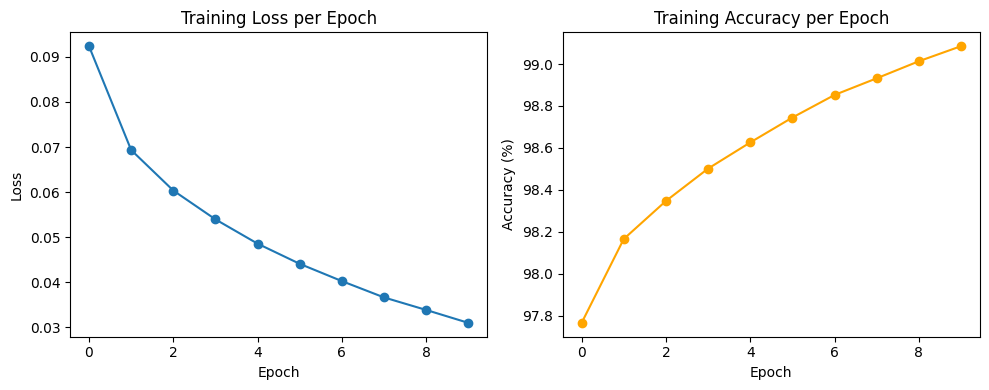

In [22]:
if not does_graph_exist:
    print("Training completed. Now visualizing training metrics...")
    # Visualize training loss and accuracy
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies, marker='o', color='orange')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping training visualization since the model was not trained in this run.")

Extract and save fc7 features for every warped patch

Loop over all warped patches, run through `feature_extractor`, and save 4096-Dim features we’ll process in batches to utilize the GPU. Each feature vector is saved as a NumPy `.npy` file named `{img_id}_{prop_idx}.npy`.  

In [23]:
# Reload the fine-tuned weights (optional but safe)
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(num_ftrs, 21)  # same architecture
net.load_state_dict(torch.load('./RCNNDataCache/alexnet_finetuned.pth'))
net = net.to(device)
net.eval()

# Build the feature extractor: up to fc7 (exclude classifier[6])
feature_extractor = nn.Sequential(
    net.features,         # conv layers
    nn.Flatten(),         # flatten conv output
    *list(net.classifier[:5])  # fc6 and fc7 layers
)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()
print("Feature extractor ready—outputs 4096-dim vectors.")

/home/lixe/RCNNLocalTest/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Feature extractor ready—outputs 4096-dim vectors.


1. We gather all warped patches (e.g., `['.../000005_0.jpg', '.../000005_1.jpg', …]`) using `glob`
2. We apply exactly the same normalization transforms (Resize => ToTensor => Normalize) as during fine-tuning
3. Using `torch.no_grad()`, we push a batch of (N,3,227,227) => get (N,4096) features, convert to NumPy, and save each vector uniquely as `{img_id}_{prop_idx}.npy` in `.RCNNDataCache/features/`

It takes damn a lot of time and file storages. I bet you had to borrow me a server-grade computer before bombarding this bombshell to me :/

![batch_feature_extraction_screenshot.png](./screenshots/batch_feature_extraction_screenshot.png)

In [24]:
from tqdm import tqdm

# Gather all patch paths
patch_list = glob.glob(os.path.join(patches_dir, '*.jpg'))
print(f"Found {len(patch_list)} patch images to extract features from.")

# Define a simple transform that matches how we normalized during fine-tuning
feat_transforms = transforms.Compose([
    transforms.Resize((227, 227)),                                  # Ensure all patches are resized to 227x227
    transforms.ToTensor(),                                          # Convert to tensor
    transforms.Normalize(mean=alexnet_mean, std=alexnet_std)        # Normalize as per AlexNet
])

def batch_feature_extraction(patch_paths, feature_extractor, batch_size=64):
    """
    Extract fc7 features for a list of patch image paths in batches.

    Args:
        patch_paths (list): List of image file paths.
        feature_extractor (nn.Module): Model up to fc7.
        batch_size (int): Batch size for processing.

    Returns:
        features (np.ndarray): Array of shape (N, 4096) with fc7 features.
        ids (list): List of (img_id, prop_idx) tuples for each patch.
    """
    features = []
    ids = []
    for i in range(0, len(patch_paths), batch_size):
        batch_files = patch_paths[i:i+batch_size]
        batch_images = []
        batch_ids = []
        for p in batch_files:
            # Extract image ID and proposal index from filename
            base = os.path.basename(p).split('.')[0]
            img_id, prop_idx_str = base.split('_')
            prop_idx = int(prop_idx_str)
            img = cv2.imread(p)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = transforms.ToPILImage()(img)
            img_tensor = feat_transforms(img)
            batch_images.append(img_tensor)
            batch_ids.append((img_id, prop_idx))
        batch_images = torch.stack(batch_images).to(device)

        with torch.no_grad():
            batch_feats = feature_extractor(batch_images)  # shape: (N, 4096)
        batch_feats = batch_feats.cpu().numpy()
        features.append(batch_feats)
        ids.extend(batch_ids)

    features = np.vstack(features)  # shape: (total_patches, 4096)
    return features, ids

# Run extraction and save features for each patch as a .npy file
for patch_path in tqdm(patch_list, desc="Extracting and saving features"):
    base = os.path.basename(patch_path).split('.')[0]
    img_id, prop_idx_str = base.split('_')
    out_path = os.path.join('./RCNNDataCache/features', f"{img_id}_{prop_idx_str}.npy")
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    if os.path.exists(out_path):
        continue  # Skip if feature already exists
    
    # Extract feature for this patch
    img = cv2.imread(patch_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = transforms.ToPILImage()(img)
    img_tensor = feat_transforms(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat_vec = feature_extractor(img_tensor).cpu().numpy().squeeze()
    np.save(out_path, feat_vec)
print("Saved all fc7 feature vectors to './RCNNDataCache/features/'")


Found 888159 patch images to extract features from.


Extracting and saving features: 100%|██████████| 888159/888159 [42:29<00:00, 348.34it/s]

Saved all fc7 feature vectors to './RCNNDataCache/features/'


Train One-vs-All SVMs using `scikit-learn`

Load Saved Feature Vectors & Labels, Train One-vs-All `LinearSVC` for each class

We’ll read back each feature `.npy` and match it to its label from `rcnn_index.txt`. Then for each of the 20 VOC classes, train a linear SVM: positives are proposals labeled = c, negatives are proposals labeled = 20 (background).

Meanwhile, it takes really a lot of RAM... If I had to run this on Colab, I had to pay. And.... it really takes a lot of times!!!

![one_vs_all_svm_training_screenshot.png](./screenshots/one_vs_all_svm_training_screenshot.png)

In [ ]:
from tqdm import tqdm
import glob

# Load index file into memory for fast lookup
# index_dict maps (img_id, prop_idx) → label for each proposal patch
index_dict = {}
with open('./RCNNDataCache/rcnn_index.txt', 'r') as f:
    for line in f:
        img_id, prop_idx_str, label_str, x, y, w, h = line.strip().split(',')
        index_dict[(img_id, int(prop_idx_str))] = int(label_str)

# Prepare data structures for SVM training
# For each class c in [0..19], gather features and ±1 labels for one-vs-all SVM
svm_models = {}
feat_files = glob.glob('./RCNNDataCache/features/*.npy')  # List of all feature files

for c in range(len(VOC_CLASSES)):
    X_pos = []  # Positive samples for class c
    X_neg = []  # Negative samples (background) for class c

    # If there's already a saved SVM for this class, skip training
    if os.path.exists(f'./RCNNDataCache/svm_{VOC_CLASSES[c]}.pkl'):
        print(f"Skipping class {VOC_CLASSES[c]}: SVM already exists.")
        continue

    # Iterate over all feature files with progress bar
    for ff in tqdm(feat_files, desc=f"Collecting features for class {VOC_CLASSES[c]}"):
        base = os.path.basename(ff).split('.')[0]
        img_id, prop_idx_str = base.split('_')
        prop_idx = int(prop_idx_str)
        label = index_dict.get((img_id, prop_idx), 20)
        feat_vec = np.load(ff)

        if label == c:
            X_pos.append(feat_vec)
        elif label == 20:
            X_neg.append(feat_vec)
        # Proposals labeled as another positive class are ignored

    # Stack features and create ±1 labels for SVM
    X_train = np.vstack([X_pos, X_neg])
    y_train = np.hstack([np.ones(len(X_pos)), -np.ones(len(X_neg))])
    print(f"Class {VOC_CLASSES[c]}: {len(X_pos)} positives, {len(X_neg)} negatives")

    # Train LinearSVC for class c (one-vs-all)
    svm = LinearSVC(C=0.01, max_iter=10000, verbose=1)
    svm.fit(X_train, y_train)

    # Save trained SVM model for this class
    joblib.dump(svm, f'./RCNNDataCache/svm_{VOC_CLASSES[c]}.pkl')
    print(f"Trained and saved SVM for class {VOC_CLASSES[c]}")
    svm_models[c] = svm

Class aeroplane: 1863 positives, 862900 negatives


Fit a `LinearRegression` (4-D) for Each Class to Refine Proposal Boxes

For every positive example (IoU ≥ 0.5 to a GT box of class c), compute the regression targets `(tx, ty, tw, th)` as in the R-CNN paper. Then train one `LinearRegression` per class to map 4096-dim features => 4-d offsets.  

In [ ]:
# Utility: Compute regression targets for a proposal vs. its best GT
def compute_regression_target(prop_box, gt_box):
    """
    Given prop_box = (xmin_p, ymin_p, xmax_p, ymax_p) and gt_box = (xmin_gt, ymin_gt, xmax_gt, ymax_gt),
    return (tx, ty, tw, th) offsets per R-CNN:
      t_x = (x_gt - x_p) / w_p,  t_y = (y_gt - y_p) / h_p,
      t_w = log(w_gt / w_p),     t_h = log(h_gt / h_p).
    Here (x_p, y_p) are centers of proposal, same for ground-truth.
    """
    xmin_p, ymin_p, xmax_p, ymax_p = prop_box
    xmin_gt, ymin_gt, xmax_gt, ymax_gt = gt_box

    w_p = xmax_p - xmin_p + 1
    h_p = ymax_p - ymin_p + 1
    x_p = xmin_p + 0.5 * w_p
    y_p = ymin_p + 0.5 * h_p

    w_gt = xmax_gt - xmin_gt + 1
    h_gt = ymax_gt - ymin_gt + 1
    x_gt = xmin_gt + 0.5 * w_gt
    y_gt = ymin_gt + 0.5 * h_gt

    t_x = (x_gt - x_p) / w_p
    t_y = (y_gt - y_p) / h_p
    t_w = np.log(w_gt / w_p)
    t_h = np.log(h_gt / h_p)
    return (t_x, t_y, t_w, t_h)

# For each class c, gather (feature_vec, target_offsets)
reg_models = {}
for c in range(len(VOC_CLASSES)):
    X_regs = []
    Y_regs = []

    # Read all index entries and match to .npy features
    with open('./RCNNDataCache/rcnn_index.txt', 'r') as f:
        for line in f:
            img_id, prop_idx_str, label_str, x_str, y_str, w_str, h_str = line.strip().split(',')
            prop_idx = int(prop_idx_str)
            label = int(label_str)
            if label != c:
                continue  # only positives for class c

            # Compute box coordinates
            x, y, w, h = map(int, [x_str, y_str, w_str, h_str])
            prop_box = (x, y, x + w, y + h)

            # Parse GT to find the exact GT box that gave IoU >= 0.5 (positive sample)
            xml_path = os.path.join(annotations_dir, f"{img_id}.xml")
            gt_objs = parse_voc_annotation(xml_path)
            best_iou = 0.0
            best_gt_box = None
            for obj in gt_objs:
                if CLASS_TO_IDX[obj['class']] != c:
                    continue
                gt_box = obj['bbox']  # (xmin,ymin,xmax,ymax)
                iou = compute_iou(prop_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_box = gt_box

            if best_gt_box is None:
                continue

            # Compute regression target
            t = compute_regression_target(prop_box, best_gt_box)  # (tx,ty,tw,th)

            # Load feature vector
            feat_path = os.path.join('./RCNNDataCache/features', f"{img_id}_{prop_idx}.npy")
            feat_vec = np.load(feat_path)
            X_regs.append(feat_vec)
            Y_regs.append(t)  # collect 4-d tuple (tx, ty, tw, th)

    if not X_regs:
        print(f"No positive samples for class {VOC_CLASSES[c]}; skipping regressor.")
        continue

    X_regs = np.vstack(X_regs)      # shape: (N_pos, 4096)
    Y_regs = np.vstack(Y_regs)      # shape: (N_pos, 4)

    # Fit LinearRegression
    reg = LinearRegression()
    reg.fit(X_regs, Y_regs)
    joblib.dump(reg, f'./RCNNDataCache/bbox_reg_{VOC_CLASSES[c]}.pkl')
    print(f"Trained and saved bbox regressor for class {VOC_CLASSES[c]} with {len(X_regs)} samples.")
    reg_models[c] = reg


### Inference & Evaluation

Build `proposals_test_dict` for VOC 2007 TEST images (50 proposals each) and Warp to (227, 227). We reuse the same Selective Search pipeline, limiting to the top 50 regions, then warp and save each cropped proposal as `{img_id}_{prop_idx}.jpg` under `./RCNNDataCache/warped_patches_test/`. 

In [ ]:
import os
import cv2
import multiprocessing as mp
from tqdm import tqdm

# Path definitions
JPEG_DIR = './VOCdevkit/VOC2007/JPEGImages'
TEST_IDS_FILE = './VOCdevkit/VOC2007/ImageSets/Main/test.txt'           # one ID per line without .jpg
proposals_test_dict = {}  
output_test_patches = './RCNNDataCache/warped_patches_test/'
os.makedirs(output_test_patches, exist_ok=True)

# Load TEST image IDs, or create the file if it does not exist
if not os.path.exists(TEST_IDS_FILE):
    # List all .jpg files in JPEG_DIR and write their names (without .jpg) to TEST_IDS_FILE
    image_files = sorted([f for f in os.listdir(JPEG_DIR) if f.lower().endswith('.jpg')])
    with open(TEST_IDS_FILE, 'w') as f:
        for img_file in image_files:
            img_id = os.path.splitext(img_file)[0]
            f.write(f"{img_id}\n")
    print(f"Created {TEST_IDS_FILE} with {len(image_files)} image IDs.")

with open(TEST_IDS_FILE, 'r') as f:
    test_ids = [line.strip() for line in f if line.strip()]
print(f"Found {len(test_ids)} test images in VOC 2007 test split.")

# Initialize Selective Search once per worker
_ss_for_test = None
def init_ss_test():
    global _ss_for_test
    _ss_for_test = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def compute_test_proposals(img_id):
    """
    Worker: load image, run SS (Fast), keep top 50, filter w/h >= 20, return (img_id, filtered_boxes).
    """
    global _ss_for_test
    img_path = os.path.join(JPEG_DIR, f"{img_id}.jpg")
    image = cv2.imread(img_path)
    if image is None:
        return (img_id, [])
    _ss_for_test.setBaseImage(image)
    _ss_for_test.switchToSelectiveSearchFast()
    rects = _ss_for_test.process()
    top50 = rects[:50]
    filtered = [r for r in top50 if r[2] >= 20 and r[3] >= 20]
    return (img_id, filtered)

# Parallelize SS over TEST images with progress reporting
num_workers = mp.cpu_count() - 3 or 1
results = []
with mp.Pool(processes=num_workers, initializer=init_ss_test) as pool:
    for idx, res in enumerate(pool.imap(compute_test_proposals, test_ids), 1):
        results.append(res)
        percent = (idx / len(test_ids)) * 100
        print(f"{idx} / {len(test_ids)} test images processed... {res[0]}: {len(res[1])} proposals ({percent:.2f}%)")

proposals_test_dict = {img_id: boxes for (img_id, boxes) in results}
print(f"Collected proposals for {len(proposals_test_dict)} test images (≤50 each).")

# Warp & Save each test proposal to 227×227
def warp_and_save_patch(image, box, out_path):
    """
    Crop ROI from `image` using (x,y,w,h), resize to (227,227), and save to out_path.
    Returns True if saved, False otherwise.
    """
    x, y, w, h = box
    x2 = min(x + w, image.shape[1] - 1)
    y2 = min(y + h, image.shape[0] - 1)
    crop = image[y : y2, x : x2]
    if crop is None or crop.size == 0:
        return False
    resized = cv2.resize(crop, (227, 227), interpolation=cv2.INTER_LINEAR)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    return cv2.imwrite(out_path, resized)

# Loop through proposals_test_dict and save warped patches
for img_id, boxes in tqdm(proposals_test_dict.items(), desc="Warping test proposals"):
    image = cv2.imread(os.path.join(JPEG_DIR, f"{img_id}.jpg"))
    if image is None:
        continue
    for idx, box in enumerate(boxes):
        out_name = f"{img_id}_{idx}.jpg"
        out_path = os.path.join(output_test_patches, out_name)
        warp_and_save_patch(image, box, out_path)

print("Finished warping and saving test proposals to './RCNNDataCache/warped_patches_test/'")


Batch-Extract 4096-Dim fc7 features using the fine-tuned AlexNet

Reuse our `feature_extractor` (AlexNet up to fc7), perform inference on every test patch in batches, and save each feature vector as `{img_id}_{prop_idx}.npy` under `./RCNNDataCache/features_test/`.  

In [ ]:
from tqdm import tqdm

# Gather all test patch paths
test_patch_list = glob.glob(os.path.join(output_test_patches, '*.jpg'))
print(f"Found {len(test_patch_list)} test patch images for feature extraction.")

# Check if features already exist for all test patches
features_dir = './RCNNDataCache/features_test/'
os.makedirs(features_dir, exist_ok=True)
all_exist = all(
    os.path.exists(os.path.join(features_dir, os.path.basename(p).replace('.jpg', '.npy')))
    for p in test_patch_list
)
if all_exist:
    print("All test features already extracted. Skipping extraction.")
else:
    print("Some test features are missing. Proceeding with extraction...")

def extract_and_save_features(patch_paths, feat_extractor, batch_size=64):
    """
    Given a list of patch_paths, run them through feat_extractor in batches.
    Save each feature vector as .npy in './RCNNDataCache/features_test/'.
    """
    os.makedirs('./RCNNDataCache/features_test/', exist_ok=True)
    for i in tqdm(range(0, len(patch_paths), batch_size), desc="Extracting features"):
        batch_files = patch_paths[i : i + batch_size]
        batch_imgs = []
        batch_ids = []

        for p in batch_files:
            base = os.path.basename(p).split('.')[0]  # example) '000005_12'
            img_id, prop_idx_str = base.split('_')
            prop_idx = int(prop_idx_str)
            img_bgr = cv2.imread(p)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            img_pil = transforms.ToPILImage()(img_rgb)
            img_tensor = feat_transforms(img_pil)
            batch_imgs.append(img_tensor)
            batch_ids.append((img_id, prop_idx))

        batch_tensor = torch.stack(batch_imgs).to(device)
        with torch.no_grad():
            feats = feat_extractor(batch_tensor)  # shape: (N,4096)
        feats_np = feats.cpu().numpy()
        for vec, (img_id, prop_idx) in zip(feats_np, batch_ids):
            save_path = f'./RCNNDataCache/features_test/{img_id}_{prop_idx}.npy'
            np.save(save_path, vec)

extract_and_save_features(test_patch_list, feature_extractor, batch_size=64)
print("Saved all test fc7 features to './RCNNDataCache/features_test/'")


Load All SVMs (`./RCNNDataCache/svm_{classname}.pkl`) and BBox Regressors (`./RCNNDataCache/bbox_reg_{classname}.pkl`), Then:

1. For each test proposal feature vector:  
   - For each class **c** (0–19; 20 VoC classes total), compute `score_c = svm_models[c].decision_function(feat_vec)`.  
   - If `score_c` <= `score_threshold_c` (we’ll use 0.0 or –1.0 by default), skip detection for this class.  
   - Otherwise, load that class’s regressor, compute `(tx, ty, tw, th) = reg.predict(feat_vec)`, adjust the original proposal `(x,y,w,h)` to get a refined box `(xmin', ymin', xmax', ymax')`.  
2. Collect all `(img_id, class_c, score_c, refined_box)` entries in a list `all_detections`.  

- - -
- We load each class’s LinearSVC and LinearRegression from disk into memory to avoid repeated I/O
- The R-CNN paper suggests a score threshold around 0.0 or –1.0; here we use 0.0 by default to reduce false positives (lower recall). You can experiment with a lower threshold if needed
- Computing (tx,ty,tw,th) and applying them exactly as in the original R-CNN gives refined boxes aligned to objects

In [ ]:
import joblib
from tqdm import tqdm

svm_models = {}
regressors = {}
for idx, cls_name in enumerate(VOC_CLASSES):
    svm_models[idx] = joblib.load(f'./RCNNDataCache/svm_{cls_name}.pkl')
    regressors[idx] = joblib.load(f'./RCNNDataCache/bbox_reg_{cls_name}.pkl')

# Helper: Convert proposal (x,y,w,h) to (xmin,ymin,xmax,ymax)
def prop_to_xyxy(box):
    x, y, w, h = box
    return (x, y, x + w, y + h)

# Helper: Apply (tx,ty,tw,th) to (xmin,ymin,xmax,ymax)
def apply_regression(orig_box, offsets):
    """
    orig_box: (xmin, ymin, xmax, ymax)
    offsets: (tx, ty, tw, th)
    Returns refined (xmin', ymin', xmax', ymax') as ints.
    """
    # Use formula from R-CNN:
    xmin, ymin, xmax, ymax = orig_box
    w = xmax - xmin + 1
    h = ymax - ymin + 1
    cx = xmin + 0.5 * w
    cy = ymin + 0.5 * h

    tx, ty, tw, th = offsets
    cx_p = tx * w + cx
    cy_p = ty * h + cy
    w_p = np.exp(tw) * w
    h_p = np.exp(th) * h

    xmin_p = int(cx_p - 0.5 * w_p)
    ymin_p = int(cy_p - 0.5 * h_p)
    xmax_p = int(cx_p + 0.5 * w_p)
    ymax_p = int(cy_p + 0.5 * h_p)
    return (xmin_p, ymin_p, xmax_p, ymax_p)

# Collect all test detections
all_detections = []  # list of dicts: {'img_id', 'class_idx', 'score', 'bbox'}

# Iterate over every test image and its proposals
for img_id, boxes in tqdm(proposals_test_dict.items(), desc="Scoring test proposals"):
    for prop_idx, box in enumerate(boxes):
        feat_path = f'./RCNNDataCache/features_test/{img_id}_{prop_idx}.npy'
        if not os.path.exists(feat_path):
            continue

        feat_vec = np.load(feat_path).reshape(1, -1)  # shape: (1,4096)
        orig_xyxy = prop_to_xyxy(box)
        
        for c in range(len(VOC_CLASSES)):
            svm = svm_models[c]
            score_c = svm.decision_function(feat_vec)[0]  # scalar

            # Threshold: keep score > 0.0 (you can tune to –1.0 for more recall)
            if score_c <= 0.0:
                continue
            
            # Refinement
            reg = regressors[c]
            offsets = reg.predict(feat_vec)[0]  # (tx, ty, tw, th)
            refined_box = apply_regression(orig_xyxy, offsets)
            all_detections.append({
                'img_id': img_id,
                'class_idx': c,
                'score': float(score_c),
                'bbox': refined_box
            })

print(f"Total raw detections (before NMS): {len(all_detections)}")

Apply Standard NMS (IoU <= 0.3) for Each Class

Group `all_detections` by `class_idx`, run NMS (threshold 0.3), and produce a final list `final_detections`.  

> NMS is a greedy algorithm that loops over all the classes, and for each class it checks for overlaps (IoU — Intersection over Union) between all the bounding boxes. If the IoU between two boxes of the same class is above a certain threshold (usually 0.7), the algorithm concludes that they refer to the same object, and discards the box with the lower confidence score (which is a product of the objectness score and the conditional class probability).

- We sort each class’s detections by descending score, then greedily remove any detection whose IoU > 0.3 with a higher-scoring box
- After NMS, we get the final set of output boxes per image & per class.

In [ ]:
from tqdm import tqdm

# Helper: Compute IoU of two boxes (xmin,ymin,xmax,ymax)
def compute_iou_xyxy(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA + 1)
    interH = max(0, yB - yA + 1)
    interArea = interW * interH

    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    union = areaA + areaB - interArea

    if union == 0:
        return 0.0
    return interArea / union

# Standard NMS function
def nms_single_class(detections, iou_thresh=0.3):
    """
    detections: list of dicts with keys ['bbox', 'score'] for a single class.
    Returns a subset of detections after NMS.
    """
    if not detections:
        return []
    
    # Sort by descending score
    detections = sorted(detections, key=lambda x: x['score'], reverse=True)
    keep = []
    while detections:
        best = detections.pop(0)
        keep.append(best)
        filtered = []
        for det in detections:
            iou = compute_iou_xyxy(best['bbox'], det['bbox'])
            if iou <= iou_thresh:
                filtered.append(det)
        detections = filtered
    return keep

# Run NMS for all classes
final_detections = []  # list of dicts: {'img_id','class_idx','score','bbox'}

for c in tqdm(range(len(VOC_CLASSES)), desc="NMS per class"):
    # Filter raw detections to only class c
    cls_dets = [d for d in all_detections if d['class_idx'] == c]
    keep_cls = nms_single_class(cls_dets, iou_thresh=0.3)
    final_detections.extend(keep_cls)
    print(f"Class {VOC_CLASSES[c]}: raw {len(cls_dets)} → NMS {len(keep_cls)}")

print(f"Total detections after NMS: {len(final_detections)}")

Save Final Detections to `./RCNNDataCache/results/` in VOC’s Required Text Format

Pascal VOC expects, for each class **c**, a file named `comp4_det_test_{classname}.txt` containing lines:
```
<image_id> <confidence> <xmin> <ymin> <xmax> <ymax>
```
in ascending order of `image_id`. We will create a folder `./RCNNDataCache/results/` and populate one file per class.  

In [ ]:
from tqdm import tqdm

# Prepare result directory
results_dir = './RCNNDataCache/results/'
os.makedirs(results_dir, exist_ok=True)

# Initialize a dict to accumulate lines per class
detection_lines = {c: [] for c in range(len(VOC_CLASSES))}

# Populate lines from final_detections
for det in tqdm(final_detections, desc="Formatting detections"):
    img_id = det['img_id']
    c = det['class_idx']
    score = det['score']
    xmin, ymin, xmax, ymax = det['bbox']
    line = f"{img_id} {score:.6f} {xmin} {ymin} {xmax} {ymax}\n"
    detection_lines[c].append(line)

# Sort lines by image_id (lexicographically)
for c in tqdm(range(len(VOC_CLASSES)), desc="Writing result files"):
    detection_lines[c].sort(key=lambda x: x.split()[0])  # sorts by img_id string
    outfile = os.path.join(results_dir, f"comp4_det_test_{VOC_CLASSES[c]}.txt")
    
    with open(outfile, 'w') as f:
        f.writelines(detection_lines[c])
    print(f"Wrote {len(detection_lines[c])} detections to {outfile}")

Run Pascal VOC 2007 Official mAP Evaluation

Use the Official Pascal VOC `voc_eval.py` Script to Compute AP per Class and mAP We will call `voc_eval.py` (shipped with Pascal VOC devkit) to parse our detection files vs. ground-truth annotations in `VOC2007/Annotations`.  

In [ ]:
# --------------------------------------------------------
# Fast/er R-CNN
# Licensed under The MIT License [see LICENSE for details]
# Written by Bharath Hariharan
# --------------------------------------------------------
# Source code: https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/datasets/voc_eval.py

import xml.etree.ElementTree as ET
import os
import _pickle as cPickle
import numpy as np

def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects

def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])

    Top level function that does the PASCAL VOC evaluation.

    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]

    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath.format(imagename))
            if i % 100 == 0:
                print('Reading annotation for {}/{}'.format(
                    i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            cPickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = cPickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'rb') as f:
        lines = f.readlines()

    # decode bytes to str before splitting
    splitlines = [x.decode('utf-8').strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]] for x in splitlines])

    # sort by confidence
    sorted_ind = np.argsort(-confidence)
    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d in range(nd):
        R = class_recs[image_ids[d]]
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)

        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap

In [ ]:
import os

cache_dir = './RCNNDataCache/annotations_cache/'
cache_file = os.path.join(cache_dir, 'annots.pkl')

if os.path.isfile(cache_file) and os.path.getsize(cache_file) == 0:
    os.remove(cache_file)
    print(f"Removed empty cache file: {cache_file}")
elif os.path.isfile(cache_file):
    print(f"Cache file {cache_file} exists and is non‐empty (size: {os.path.getsize(cache_file)} bytes).")
else:
    print(f"No cache file found at: {cache_file}")

In [ ]:
import os

VOC_ROOT = './VOCdevkit/VOC2007'
ANNOPATH = os.path.join(VOC_ROOT, 'Annotations', '{}.xml')
DETPATH  = './RCNNDataCache/results/comp4_det_test_{}.txt'
IMAGESETFILE = os.path.join(VOC_ROOT, 'ImageSets', 'Main', 'test.txt')
CACHEDIR = './RCNNDataCache/annotations_cache/'
os.makedirs(CACHEDIR, exist_ok=True)

aps = []
for c, cls_name in enumerate(VOC_CLASSES):
    rec, prec, ap = voc_eval(
        DETPATH,
        ANNOPATH,
        IMAGESETFILE,
        cls_name,
        CACHEDIR,
        ovthresh=0.5,
        use_07_metric=True
    )
    aps.append(ap)
    print(f"AP for {cls_name:12s} = {ap:.4f}")

mAP = sum(aps) / len(aps)
print(f"\n===== VOC2007 mAP (50 proposals) = {mAP:.4f} =====")

In [ ]:
import cv2, matplotlib.pyplot as plt
from random import choice

# Pick a class where you at least see some lines in the result file, e.g. "person"
cls = 'person'
dets = []
with open(f'RCNNDataCache/results/comp4_det_test_{cls}.txt') as f:
    for line in f:
        img_id, score, xmin, ymin, xmax, ymax = line.split()
        dets.append((img_id, float(score), int(xmin), int(ymin), int(xmax), int(ymax)))

# Pick a random detection
img_id, score, x1, y1, x2, y2 = choice(dets)
img = cv2.imread(f'VOCdevkit/VOC2007/JPEGImages/{img_id}.jpg')
cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"{cls} | score={score:.2f} | image={img_id}")
plt.axis('off')
plt.show()
